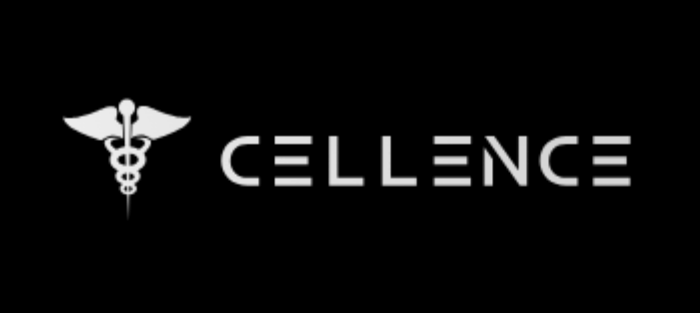

Cellence an Drug Discovery Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(
    "jonghyunlee/MolGPT_long_context_pretrained-by-ZINC15"
)
model = AutoModelForCausalLM.from_pretrained(
    "jonghyunlee/MolGPT_long_context_pretrained-by-ZINC15"
)

"""
    Python Function to Generate SMILES ! 
"""

def generate_smiles(prompt="C", max_length=60, num_return_sequences=100):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    attention_mask = (input_ids != tokenizer.pad_token_id)
    outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,
        do_sample=True,
        top_k=50,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        pad_token_id=tokenizer.eos_token_id
    )
    smiles_list = [tokenizer.decode(out, skip_special_tokens=True) for out in outputs]
    return smiles_list

#len_of_gen_smiles = int(input("Enter the Number of SMILES you want to Generate : "))

a = generate_smiles()
print(a)

In [ ]:
from rdkit import Chem
from rdkit import RDLogger

# Function to check the Vaild Smiles 

RDLogger.DisableLog('rdApp.*') 

def validate_smiles(smiles_list):
    """
    This Function uses Rdkit to check the proper 
    """
    valid = set()
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol:
            valid.add(Chem.MolToSmiles(mol))  # canonicalize
    return list(valid)

In [ ]:
generated = generate_smiles()
print("Generated:", generated)
valid = validate_smiles(generated)
print("Valid:", valid)

In [ ]:
from DeepPurpose import DTI as models
from DeepPurpose import utils

model = models.model_pretrained(model='CNN_CNN_BindingDB')

def score_molecules(smiles_list, target_seq):
    data = utils.data_process(
        smiles_list,
        [target_seq] * len(smiles_list),
        y=[0] * len(smiles_list),  
        drug_encoding=model.drug_encoding,
        target_encoding=model.target_encoding,
        split_method='no_split'
    )

    scores = model.predict(data)
    results = list(zip(smiles_list, scores))
    results.sort(key=lambda x: x[1], reverse=True)  
    return results

In [ ]:
target_seq = input("Enter the Valid Protein Sequence : ")
v = valid
aa = score_molecules(v, target_seq)

for i, (smile, score) in enumerate(aa[:5], 1):
    print(f"{i}. SMILES: {smile[:60]}... | Score: {score:.4f}")

In [ ]:
import csv
from datetime import datetime

output_file = f"ranked_smiles_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"

with open(output_file, mode="w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["SMILES", "Binding Score"])
    for smiles, score in aa:
        writer.writerow([smiles, score])

In [ ]:
import csv
from datetime import datetime
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

def admet_properties_to_csv(smiles_list):
    results = []

    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            results.append({'SMILES': smi, 'Valid': False})
            continue

        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        tpsa = rdMolDescriptors.CalcTPSA(mol)
        rot_bonds = rdMolDescriptors.CalcNumRotatableBonds(mol)

        lipinski = (
            mw <= 500 and
            logp <= 5 and
            hbd <= 5 and
            hba <= 10
        )

        results.append({
            'SMILES': smi,
            'Valid': True,
            'MW': round(mw, 2),
            'LogP': round(logp, 2),
            'HBD': hbd,
            'HBA': hba,
            'TPSA': round(tpsa, 2),
            'RotatableBonds': rot_bonds,
            'LipinskiPass': lipinski
        })


    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    output_path = f"admet_properties_{timestamp}.csv"


    fieldnames = results[0].keys()
    with open(output_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for row in results:
            writer.writerow(row)

    print(f"The Adment Properties has been saved to {output_path}")


admet_properties_to_csv(v)


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from datetime import datetime
import os


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
folder = f"smiles_img_{timestamp}"
os.makedirs(folder, exist_ok=True)

for i, (smile, score) in enumerate(aa[:5], 1):
    m = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(m)
    img.save(os.path.join(folder, f"molecule_{i}.png"))

print(f"Saved images in: {folder}")


Thank You ! 

for visiting my code ! 
